In [2]:
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!pip install seaborn
!pip install gradio

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import tensorflow as tf  # Core TensorFlow library

from tensorflow.keras import layers, models, optimizers, callbacks  # Layers, model creation, optimizers, and training callbacks

from tensorflow.keras.models import Sequential, load_model  # For sequential model architecture and loading saved models

from tensorflow.keras.applications import EfficientNetV2B2  # Pretrained EfficientNetV2B0 model for transfer learning

from tensorflow.keras.applications.efficientnet import preprocess_input  # Preprocessing function specific to EfficientNet

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

import numpy as np  # Numerical operations and array handling

import matplotlib.pyplot as plt  # Plotting graphs and images

import seaborn as sns  # Plotting graphs and images

from sklearn.metrics import confusion_matrix, classification_report  # Evaluation metrics for classification models

import gradio as gr  # Web interface library to deploy and test ML models

from PIL import Image  # For image file loading and basic image operations


In [5]:
trainpath = r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/train' # <-- Make sure this path is correct
testpath= r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/test'
validpath = r'C:/Users/praro/Downloads/E-Waste classification dataset/modified-dataset/val'


In [6]:
datatrain= tf.keras.utils.image_dataset_from_directory(trainpath,shuffle = True, image_size = (224, 224), batch_size = 32, validation_split= False)
datatest=tf.keras.utils.image_dataset_from_directory(testpath,shuffle = False, image_size = (224, 224), batch_size = 32, validation_split= False)
datavalid = tf.keras.utils.image_dataset_from_directory(validpath,shuffle = True, image_size = (224, 224), batch_size = 32, validation_split= False)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [7]:
print(len(datatrain.class_names))
class_names = datatrain.class_names
print(class_names)

10
['Battery', 'Keyboard', 'Microwave', 'Mobile', 'Mouse', 'PCB', 'Player', 'Printer', 'Television', 'Washing Machine']


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

datatrain = datatrain.map(lambda x, y: (preprocess_input(x), y)).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
datavalid = datavalid.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
datatest = datatest.map(lambda x, y: (preprocess_input(x), y)).cache().prefetch(buffer_size=AUTOTUNE)
#


In [9]:
from tensorflow.keras.applications import EfficientNetV2B2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

input_shape = (224, 224, 3)
num_classes = 10  # change if needed

base_model = EfficientNetV2B2(include_top=False, input_shape=input_shape, weights='imagenet')
base_model.trainable = True  # Enable fine-tuning

# ✅ Freeze initial layers, unfreeze top 50
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Classification head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  # ✅ Add dropout
output = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [10]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=loss,
    metrics=['accuracy']
)


In [11]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience=2, factor=0.5, verbose=1)
]


In [12]:
history = model.fit(
    datatrain,
    validation_data=datavalid,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 128s 1s/step - accuracy: 0.4486 - loss: 1.8416 - val_accuracy: 0.9367 - val_loss: 0.5236 - learning_rate: 1.0000e-04
Epoch 2/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9212 - loss: 0.4813 - val_accuracy: 0.9567 - val_loss: 0.2024 - learning_rate: 1.0000e-04
Epoch 3/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 59s 790ms/step - accuracy: 0.9610 - loss: 0.2020 - val_accuracy: 0.9700 - val_loss: 0.1349 - learning_rate: 1.0000e-04
Epoch 4/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 58s 780ms/step - accuracy: 0.9685 - loss: 0.1257 - val_accuracy: 0.9767 - val_loss: 0.1097 - learning_rate: 1.0000e-04
Epoch 5/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - accuracy: 0.9805 - loss: 0.0829 - val_accuracy: 0.9733 - val_loss: 0.1032 - learning_rate: 1.0000e-04
Epoch 6/25
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 766ms/step - accuracy: 0.9876 - loss: 0.0584
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
75/75 ━━━━━━━━━━━━━━━━━━━━ 63s 840ms/step - accuracy: 0.9

In [13]:
test_loss, test_acc = model.evaluate(datatest)
print(f"Test Accuracy: {test_acc * 100:.2f}%, Test Loss: {test_loss:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 554ms/step - accuracy: 0.9605 - loss: 0.1011
Test Accuracy: 96.67%, Test Loss: 0.1013


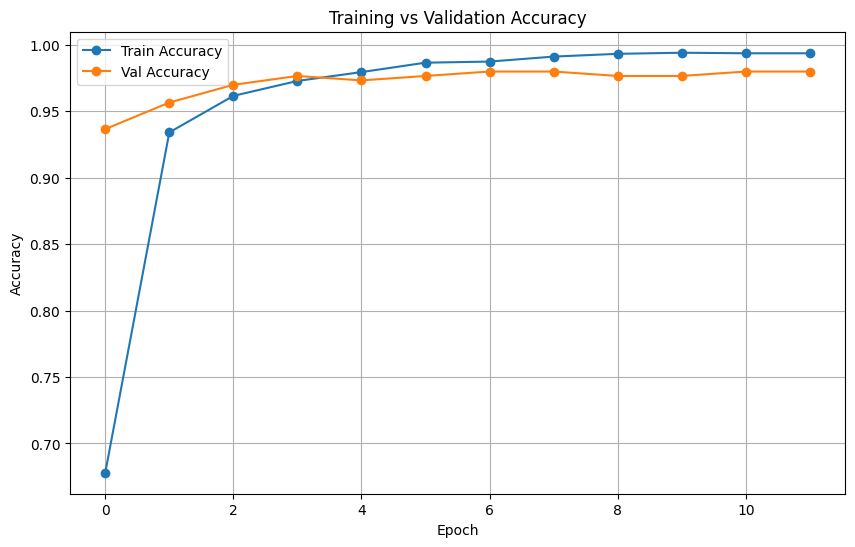

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Val Accuracy', marker='o')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()





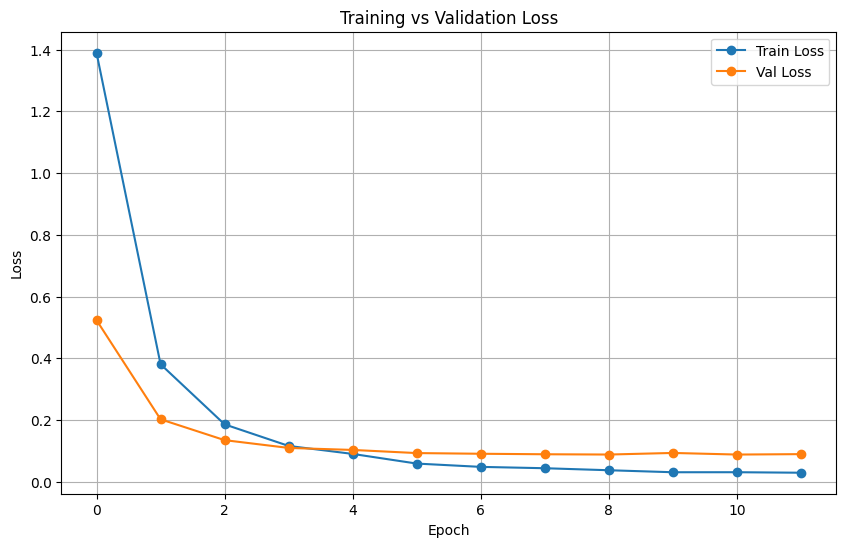

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Val Loss', marker='o')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [16]:
y_true = np.concatenate([y.numpy() for x, y in datatest], axis=0)  # Ground truth labels

# Get predictions as probabilities and then predicted classes
y_pred_probs = model.predict(datatest)

# Class with highest probability
y_pred = np.argmax(y_pred_probs, axis=1)                           

# Print confusion matrix and classification report
print(confusion_matrix(y_true, y_pred))                            
print(classification_report(y_true, y_pred))    


10/10 ━━━━━━━━━━━━━━━━━━━━ 12s 974ms/step
[[27  0  0  0  0  1  0  1  0  1]
 [ 0 30  0  0  0  0  0  0  0  0]
 [ 0  0 29  0  0  0  0  0  1  0]
 [ 0  0  0 29  0  0  0  0  1  0]
 [ 0  0  0  0 30  0  0  0  0  0]
 [ 0  0  0  0  0 30  0  0  0  0]
 [ 0  0  0  0  0  0 30  0  0  0]
 [ 1  0  0  0  0  0  1 28  0  0]
 [ 0  0  1  0  0  0  1  0 28  0]
 [ 1  0  0  0  0  0  0  0  0 29]]
              precision    recall  f1-score   support

           0       0.93      0.90      0.92        30
           1       1.00      1.00      1.00        30
           2       0.97      0.97      0.97        30
           3       1.00      0.97      0.98        30
           4       1.00      1.00      1.00        30
           5       0.97      1.00      0.98        30
           6       0.94      1.00      0.97        30
           7       0.97      0.93      0.95        30
           8       0.93      0.93      0.93        30
           9       0.97      0.97      0.97        30

    accuracy                   

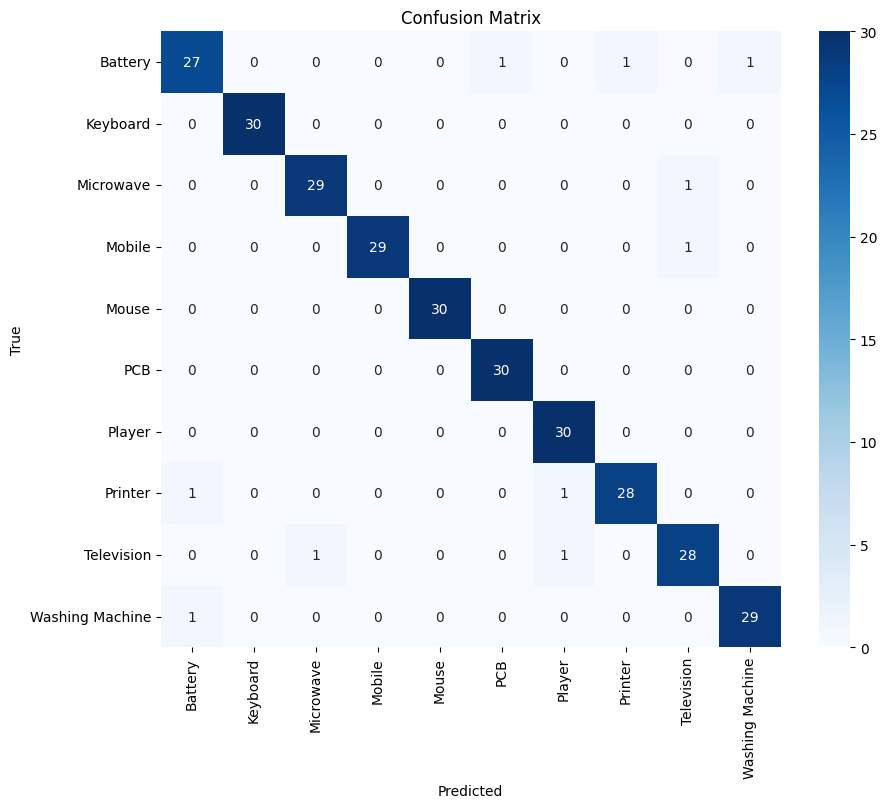

In [17]:
cm = confusion_matrix(y_true, y_pred)                                     # Compute confusion matrix
                                                     # Import seaborn for visualization

plt.figure(figsize=(10, 8))                                               # Set figure size
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names, 
            yticklabels=class_names, 
            cmap='Blues')                                                 # Create heatmap with class labels

plt.xlabel('Predicted')                                                   # Label for x-axis
plt.ylabel('True')                                                        # Label for y-axis
plt.title('Confusion Matrix')                                             # Title for the plot
plt.show()                                                                # Display the plot


In [18]:
model.save('Efficient_classify_prakriti_improved.keras')